In [295]:
#!c1.32
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [ ]:
## Read data

In [238]:
#!c1.32
df = pd.DataFrame()
for filename in tqdm(os.listdir('./LaggedFeatures')): 
    if filename!='.ipynb_checkpoints':
        data = pd.read_csv(f'./LaggedFeatures/{filename}', sep = ',')
        df = df.append(data)

KeyboardInterrupt: 

In [4]:
#!c1.8
df = df.reset_index(drop = True)

In [12]:
#!c1.8
print(df.shape)

(12002637, 140)


In [13]:
#!c1.8
df.rename(columns = {'product_rk' :'PRODUCT_RK', 'store_location_rk':'STORE_LOCATION_RK'}, inplace = True)

## Merge products

In [296]:
#!c1.32
product_dict = pd.read_csv('PRODUCT.csv', sep=';')

In [297]:
#!c1.32
prod_cols = product_dict.columns[product_dict.columns.str.contains('RK')]

In [298]:
#!c1.32
loc_dict = pd.read_csv('LOCATION.csv', sep=';')

In [299]:
#!c1.32
loc_cols = loc_dict.columns[loc_dict.columns.str.contains('RK')]

In [ ]:
#!c1.8
df_merged = df_merged.merge(loc_dict[loc_cols], how='left', on='STORE_LOCATION_RK')

## Clustering 

In [20]:
#!c1.8
df_merged['period_start_dt'].max()

'2019-12-30'

In [21]:
#!c1.8
df = []

In [3]:
#!c1.8
train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 91.0% of data
Test contains 9.0% of data


## By PRODUCT_LVL_RK3

In [23]:
#!c1.8
## calculate mean demand for every pair product-city

demand_loc = pd.pivot_table(df_merged_train.groupby(['STORE_LOCATION_RK', 'PRODUCT_LVL_RK3'])['demand'].mean().reset_index(), 
                                      index='STORE_LOCATION_RK', values='demand', columns='PRODUCT_LVL_RK3', fill_value=0).rename_axis(None, axis=1)
demand_loc.columns = demand_loc.columns.astype(str)
demand_loc.head()



,1938,3480,3752,4455,4782,4871,5067,6051,6966,7153,7175,7182,7308,7431,7477,7728,9965,10045,10125,11059,11108,11183,72628,72641,72745,72798,72862,73077,73613,112144,112574,112598,113535
STORE_LOCATION_RK,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
317,0.0,0.431750,0.237829,0.299054,1.758058,0.442426,1.563540,0.000000,0.000000,2.353323,0.0,0.893631,0.239106,0.332644,0.435559,0.669020,0.650588,0.900450,0.981023,0.515539,0.000000,1.317203,0.604301,0.857008,0.465636,0.148719,1.231591,0.0,0.756879,0.0,10.225303,0.371904,0.743175
355,0.0,0.608806,0.314096,0.470802,2.263330,0.571548,1.951281,0.000000,0.000000,3.318379,0.0,0.928957,0.383563,0.335200,0.307410,0.783681,0.551368,0.864012,1.218763,0.826569,1.153846,1.555815,0.440387,1.245314,0.481641,0.293660,1.565067,0.0,0.748082,0.0,13.519663,0.371057,0.889520
380,0.0,0.524081,0.298441,0.332777,2.108833,0.526194,1.638058,0.376775,0.000000,2.247812,0.0,0.809176,0.247817,0.349385,0.418854,0.674988,0.533415,0.767963,1.080680,0.498385,1.000000,1.577008,0.706584,0.921757,0.411676,0.239635,1.352205,0.0,0.651753,0.0,14.494449,0.376492,0.763178
425,0.0,0.603273,0.299025,0.419331,2.717668,0.605154,1.887312,0.000000,0.000000,3.190336,0.0,0.828380,0.362167,0.257035,0.429192,0.657850,0.508233,1.034929,1.237045,0.693659,1.250000,1.550971,0.506962,1.222530,0.467512,0.239371,1.547213,0.0,0.775539,0.0,18.739651,0.388773,0.795932
453,0.0,0.566113,0.304520,0.376702,3.314394,0.719413,1.998232,0.375671,0.506139,2.798415,0.0,0.842895,0.257774,0.423904,0.579689,0.703340,0.556718,0.829995,1.021561,0.686741,0.933925,1.617953,0.597347,1.015628,0.445624,0.235212,1.444004,0.0,0.796509,0.0,13.654529,0.336945,0.776393


In [24]:
#!c1.8
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [25]:
#!c1.8
## how to define number of clusters?
for i in range(3,20):
    agcl =  AgglomerativeClustering(n_clusters=i)
    cluster_labels = agcl.fit_predict(demand_loc)

    ## add labels to dataset
    demand_loc[f'label_{i}'] = cluster_labels
    df_merged = df_merged.merge(demand_loc.reset_index()[['STORE_LOCATION_RK', f'label_{i}']],
                                copy=False, on='STORE_LOCATION_RK')
df_merged = df_merged.sort_values('period_start_dt')
df_merged.head()

,PRODUCT_RK,STORE_LOCATION_RK,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,PROMO12_FLAG,NO_FILTER,demand_lag4_w112D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag4_w112D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag4_w224D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag4_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag4_w728D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag4_w728D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag4_w1456D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag4_w1456D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag8_w112D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag8_w112D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag8_w224D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag8_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag8_w728D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag8_w728D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag8_w1456D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag8_w1456D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag26_w112D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag26_w112D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag26_w224D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag26_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag26_w728D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag26_w728D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag26_w1456D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag26_w1456D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag52_w112D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag52_w112D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmean_PROMO1_FLAG_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_PROMO1_FLAG_dynamic_rolling,...,demand_lag26_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag26_w728D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag26_w728D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag26_w1456D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag26_w1456D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w112D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w112D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w728D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w728D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w1456D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER

In [27]:
#!c1.8
df_merged.to_parquet('merged_df_segmentation.parquet')

In [28]:
#!c1.8
demand_loc = []

In [300]:
#!c1.32
df_merged = pd.read_parquet('merged_df_segmentation.parquet')

## Predictions

### Splitting data

In [301]:
#!c1.32
## now with labels
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 91.0% of data
Test contains 9.0% of data


In [302]:
#!c1.32
lag_cols = df_merged_train.columns[df_merged_train.columns.str.contains('demand_')]
train_cols = list(lag_cols) + list(prod_cols) + list(loc_cols)

X_train, y_train = df_merged_train[train_cols], df_merged_train['demand']
X_test, y_test = df_merged_test[train_cols], df_merged_test['demand']

### No clustering

In [272]:
#!c1.32
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

cat = CatBoostRegressor(iterations=100, verbose=0)
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [2, 4, 6, 8]}

grid_search_result = cat.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2.915529177
bestIteration = 99

0:	loss: 2.9155292	best: 2.9155292 (0)	total: 26.5s	remaining: 4m 51s

bestTest = 2.773468915
bestIteration = 99

1:	loss: 2.7734689	best: 2.7734689 (1)	total: 46.3s	remaining: 3m 51s

bestTest = 2.752510185
bestIteration = 99

2:	loss: 2.7525102	best: 2.7525102 (2)	total: 1m 6s	remaining: 3m 18s

bestTest = 2.880117293
bestIteration = 99

3:	loss: 2.8801173	best: 2.7525102 (2)	total: 1m 29s	remaining: 2m 58s

bestTest = 2.734584251
bestIteration = 99

4:	loss: 2.7345843	best: 2.7345843 (4)	total: 1m 53s	remaining: 2m 39s

bestTest = 2.707895114
bestIteration = 99

5:	loss: 2.7078951	best: 2.7078951 (5)	total: 2m 19s	remaining: 2m 19s

bestTest = 2.856437303
bestIteration = 99

6:	loss: 2.8564373	best: 2.7078951 (5)	total: 2m 48s	remaining: 2m

bestTest = 2.701894564
bestIteration = 99

7:	loss: 2.7018946	best: 2.7018946 (7)	total: 3m 19s	remaining: 1m 39s

bestTest = 2.672423828
bestIteration = 99

8:	loss: 2.6724238	best: 2.6724238 (8)	tota

In [278]:
#!c1.32
cat = CatBoostRegressor(iterations=100, verbose=0)
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [8, 10, 15, 20]}

grid_search_result_2 = cat.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2.834324077
bestIteration = 99

0:	loss: 2.8343241	best: 2.8343241 (0)	total: 44.5s	remaining: 8m 9s

bestTest = 2.678370231
bestIteration = 99

1:	loss: 2.6783702	best: 2.6783702 (1)	total: 1m 23s	remaining: 6m 57s

bestTest = 2.651629517
bestIteration = 99

2:	loss: 2.6516295	best: 2.6516295 (2)	total: 2m 2s	remaining: 6m 6s

bestTest = 2.816072566
bestIteration = 99

3:	loss: 2.8160726	best: 2.6516295 (2)	total: 4m 26s	remaining: 8m 52s

bestTest = 2.662454788
bestIteration = 99

4:	loss: 2.6624548	best: 2.6516295 (2)	total: 6m 56s	remaining: 9m 43s

bestTest = 2.645159133
bestIteration = 92

5:	loss: 2.6451591	best: 2.6451591 (5)	total: 9m 27s	remaining: 9m 27s

bestTest = 2.787416878
bestIteration = 99

6:	loss: 2.7874169	best: 2.6451591 (5)	total: 19m 43s	remaining: 14m 5s

bestTest = 2.648044406
bestIteration = 99

7:	loss: 2.6480444	best: 2.6451591 (5)	total: 30m 16s	remaining: 15m 8s

bestTest = 2.638311964
bestIteration = 98

8:	loss: 2.6383120	best: 2.6383120 (8)

In [279]:
#!c1.32
print(grid_search_result_2['params'])

{'depth': 15, 'learning_rate': 0.1}


In [287]:
#!c1.32
best_params_2 = {'depth': 15, 'learning_rate': 0.1}

In [288]:
#!c1.32
cat = CatBoostRegressor(iterations=100, verbose=0, **best_params_2)
cat.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [289]:
#!c1.32
preds = cat.predict(X_test)

In [290]:
#!c1.32
rmse = mean_squared_error(preds, y_test, squared = False)
print('Error without clustering:', rmse)

Error without clustering: 2.5214153290557317


In [273]:
#!c1.32
best_params = grid_search_result['params']

In [291]:
#!c1.32
best_params = {'depth': 8, 'learning_rate': 0.1}

In [274]:
#!c1.32
print(best_params)

{'depth': 8, 'learning_rate': 0.1}


In [292]:
#!c1.32
cat = CatBoostRegressor(**best_params)
cat.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.7683395	total: 502ms	remaining: 8m 21s
1:	learn: 2.7232438	total: 861ms	remaining: 7m 9s
2:	learn: 2.6845487	total: 1.25s	remaining: 6m 54s
3:	learn: 2.6521054	total: 1.66s	remaining: 6m 52s
4:	learn: 2.6229638	total: 2.07s	remaining: 6m 51s
5:	learn: 2.5971753	total: 2.5s	remaining: 6m 54s
6:	learn: 2.5736937	total: 2.92s	remaining: 6m 53s
7:	learn: 2.5561349	total: 3.43s	remaining: 7m 5s
8:	learn: 2.5415247	total: 3.98s	remaining: 7m 17s
9:	learn: 2.5279384	total: 4.66s	remaining: 7m 41s
10:	learn: 2.5161589	total: 5.88s	remaining: 8m 48s
11:	learn: 2.5045710	total: 6.39s	remaining: 8m 46s
12:	learn: 2.4957964	total: 6.81s	remaining: 8m 36s
13:	learn: 2.4878134	total: 7.25s	remaining: 8m 30s
14:	learn: 2.4809294	total: 7.83s	remaining: 8m 34s
15:	learn: 2.4739465	total: 8.23s	remaining: 8m 26s
16:	learn: 2.4684475	total: 8.68s	remaining: 8m 22s
17:	learn: 2.4640900	total: 9.13s	remaining: 8m 18s
18:	learn: 2.4602489	total: 9.62s	remaining: 8m 16s
19:	learn: 2.4557511	tota

In [293]:
#!c1.8
preds = cat.predict(X_test)

In [294]:
#!c1.8
rmse = mean_squared_error(preds, y_test, squared = False)
print('Error without clustering:', rmse)

Error without clustering: 2.566156051634232


Text(0.5, 1.0, 'Feature Importance')

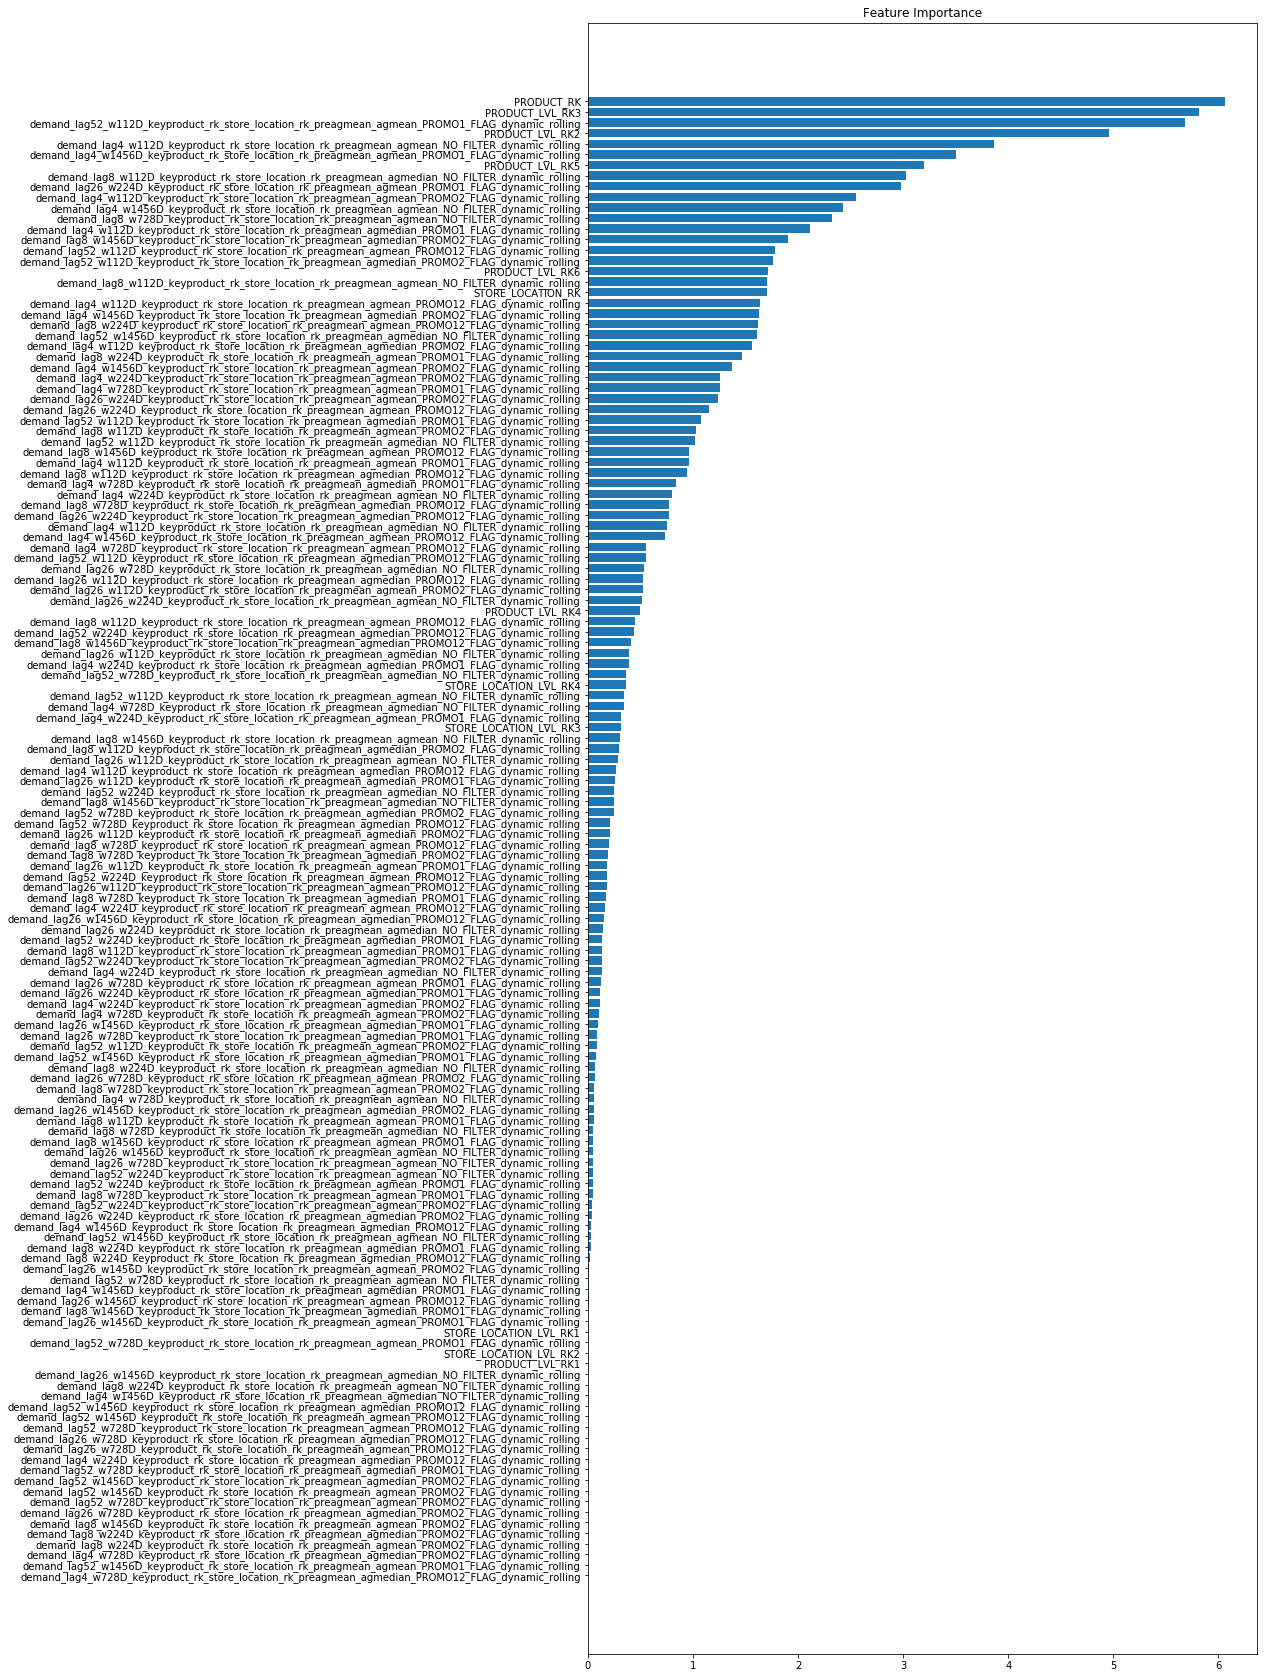

In [32]:
#!c1.8
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test[train_cols].columns)[sorted_idx])
plt.title('Feature Importance')


In [9]:
#!c1.32
X_train.shape[0]

10915277

In [15]:
#!c1.32
cat = CatBoostRegressor(iterations=100, verbose=0)
res = pd.DataFrame(columns = {'label', 'rmse'})
for i in tqdm(np.arange(0.025, 1.001, 0.025)):
    cat = CatBoostRegressor(iterations=100, verbose=0)
    X_sample = X_train.sample(frac = i)
    y_sample = y_train[X_sample.index]
    cat.fit(X_sample, y_sample)
    preds = cat.predict(X_test)
    rmse = mean_squared_error(preds, y_test, squared = False)
    res = res.append({'label':i, 'rmse':rmse}, ignore_index = True)

In [16]:
#!c1.32
res

,label,rmse
0,0.025,2.639582
1,0.050,2.612782
2,0.075,2.693363
3,0.100,2.639787
4,0.125,2.640928
5,0.150,2.662712
6,0.175,2.618351
7,0.200,2.572005
8,0.225,2.640300
9,0.250,2.762468


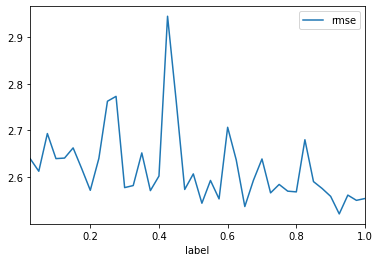

In [18]:
#!c1.32
res.plot(x = 'label', y = 'rmse')

In [303]:
#!c1.32
cat = CatBoostRegressor(iterations=100, verbose=0)
res = pd.DataFrame(columns = {'label', 'rmse'})
for i in tqdm(np.arange(0.01, 1.001, 0.01)):
    cat = CatBoostRegressor(iterations=100, verbose=0)
    X_sample = X_train.sample(frac = i)
    y_sample = y_train[X_sample.index]
    cat.fit(X_sample, y_sample)
    preds = cat.predict(X_test)
    rmse = mean_squared_error(preds, y_test, squared = False)
    res = res.append({'label':i, 'rmse':rmse}, ignore_index = True)

<Figure size 1440x720 with 0 Axes>

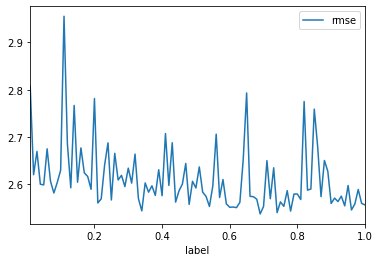

In [304]:
#!c1.32
plt.figure(figsize=(20, 10))
res.plot(x = 'label', y = 'rmse')

In [306]:
#!c1.32
from sklearn.metrics import mean_absolute_error
cat = CatBoostRegressor(iterations=100, verbose=0)
res = pd.DataFrame(columns = {'label', 'mae'})
for i in tqdm(np.arange(0.01, 1.001, 0.01)):
    cat = CatBoostRegressor(iterations=100, verbose=0)
    X_sample = X_train.sample(frac = i)
    y_sample = y_train[X_sample.index]
    cat.fit(X_sample, y_sample)
    preds = cat.predict(X_test)
    mae = mean_absolute_error(preds, y_test)
    res = res.append({'label':i, 'mae':mae}, ignore_index = True)

<Figure size 1440x720 with 0 Axes>

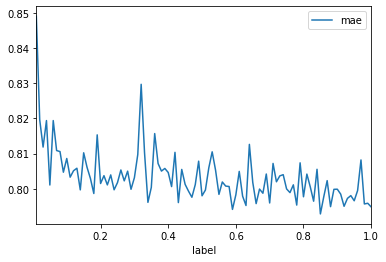

In [307]:
#!c1.32
plt.figure(figsize=(20, 10))
res.plot(x = 'label', y = 'mae')